# Numerical Example 2
# **Weights initialization analysis of PINN eikonal solver for a smooth model**

# Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import random
from tqdm import tqdm
from torchinfo import summary
from curvature.curvatures import Diagonal, KFAC, EFB, INF

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Device Configuration

In [2]:
# PyTorch random number generator
torch.manual_seed(4321)

# Random number generations in other libraries
np.random.seed(4321)

# Device configuration
device = torch.device(1 if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda:1


# PINN Class

In [3]:
class PINN(nn.Module):
    """
    Build a physics informed neural network (PINN) model for Eikonal equation.

    Attributes:
    layers: list of hidden units for each layers
    """

    def __init__(self, init='kaiming_normal'):
        """
        Build a physics informed neural network (PINN) model.

        Args:
        layers: list of hidden units for each layers
        """
        super().__init__()      # inherite __init__ from parent class

        # initialize neural network as a list using nn.ModuleList
        self.linears = nn.Sequential(
                        nn.Linear(2,16),
                        nn.Mish(),
                        nn.Linear(16,16),
                        nn.Mish(),
                        nn.Linear(16,32),
                        nn.Mish(),
                        nn.Linear(32,32),
                        nn.Mish(),
                        nn.Linear(32,16),
                        nn.Mish(),
                        nn.Linear(16,16),
                        nn.Mish(),
                        nn.Linear(16, 1),
                        )
        
        self.model_initialization(init)

    # initialization
    def model_initialization(self, init='kaiming_normal'):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
                elif init == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
                elif init == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0) 
                elif init == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
                else:
                    raise NotImplementedError("I'm lazy to implement.")

    # forward propagation
    def forward(self, x):
        """
        Forward model of physics informed neural network (PINN).

        Args:
        x: inputs
        """
        return self.linears(x)

# Loss Function Class

In [4]:
class LossEikonal(nn.Module):
  """
  Create a loss function for Eikonal equation 
  physics informed neural network (PINN).

  Attributes:
    model: PINN model
    T0: smooth background travel time.
    px0: smooth background travel time derivative w.r.t x
    pz0: smooth background travel time derivative w.r.t z
    vel: smooth background velocity model
    sids: source indices
  """

  def __init__(self):
    super().__init__()
    self.loss = nn.MSELoss()

  def forward(self, model, params):
    """
    Compute loss function for Eikonal equation 
    physics informed neural network (PINN).

    Args:
      tau: the PINN predictions
      dataset: current dataset

    Returns:
      loss: Tensor of loss value
    """
    
    vel = params['vel']
    inputs = params['input']
    data_pts = params['data_pts']
    data = params['data']

    # compute derivative of tau
    tau = model(inputs)
    tau_data = model(data_pts)

    g = ag.grad(outputs=tau, inputs=inputs, 
                grad_outputs=torch.ones_like(tau), create_graph=True)[0]

    dtau_dz = g[..., 0].reshape(-1, 1)
    dtau_dx = g[..., 1].reshape(-1, 1)

    # compute eikonal loss
    loss_eqn = self.loss((dtau_dx)**2 + (dtau_dz)**2, 1.0/(vel)**2)

    # compute eikonal equation solution constraint with Heaviside function
    loss_heav = self.loss((1 - torch.sign(tau))*torch.abs(tau), torch.zeros_like(tau))

    # compute source constraint for eikonal equation
    loss_data = self.loss(tau_data, data)

    return loss_eqn + loss_data + loss_heav, loss_eqn, loss_data

# Model Specifications

In [5]:
v0 = torch.tensor([2.0])      # velocity at the origin of the model
vergrad = torch.tensor([0.5]) # vertical gradient
horgrad = torch.tensor([0.0]) # horizontal gradient

zmin = 0.0
zmax = 2.0
deltaz = 0.02

xmin = 0.0
xmax = 3.0
deltax = 0.02

# point-source location
sz = torch.tensor([1.0])
sx = torch.tensor([1.5])

# number of training points
num_tr_pts = 2501

# Generate dataset

In [6]:
# creating grid, calculating reference traveltimes,
# and prepare list of grid points for training (X_star)

z = torch.arange(zmin, zmax + deltaz, deltaz)

x = torch.arange(xmin, xmax + deltax, deltax)

Z, X = torch.meshgrid(z, x)

# preparing velocity model
vs = v0 + vergrad*sz + horgrad*sx     # velocity at the source location
velmodel = vs + vergrad*(Z - sz) + horgrad*(X - sx)

# travel-time solution
if vergrad == 0 and horgrad == 0:
  # for homogenous velocity model
  T_data = torch.sqrt((Z - sz)**2 + (X - sx)**2) / v0
else:
  # for velocity gradient model
  T_data = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs)*
                      (vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2)) /
                      torch.sqrt(vergrad**2 + horgrad**2))

# data
data_pts = np.hstack([torch.arange(0, 151, 15),])

data = T_data.reshape(-1, 1)[data_pts].requires_grad_(False).to(device)
Zd = Z.reshape(-1, 1)[data_pts]
Xd = X.reshape(-1, 1)[data_pts]

# training
selected_pts = np.random.choice(np.arange(Z.numel()), num_tr_pts, replace=False)
Zf = Z.reshape(-1, 1)[selected_pts]
Xf = X.reshape(-1, 1)[selected_pts]

# velocity
velmodelf = velmodel.reshape(-1, 1)[selected_pts].requires_grad_(False).to(device)

# grid points for training
trainset = torch.hstack((Zf, Xf)).requires_grad_(True).to(device)

# grid points for data
dataset = torch.hstack((Zd, Xd)).to(device)

# grid points for prediction
testset = torch.hstack((Z.reshape(-1, 1), X.reshape(-1, 1))).to(device)

# params
params = {'vel':velmodelf, 'input':trainset, 'data_pts':dataset, 'data':data}

/home/izzatum/anaconda3/envs/AFWI/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Plot the velocity model with the source location

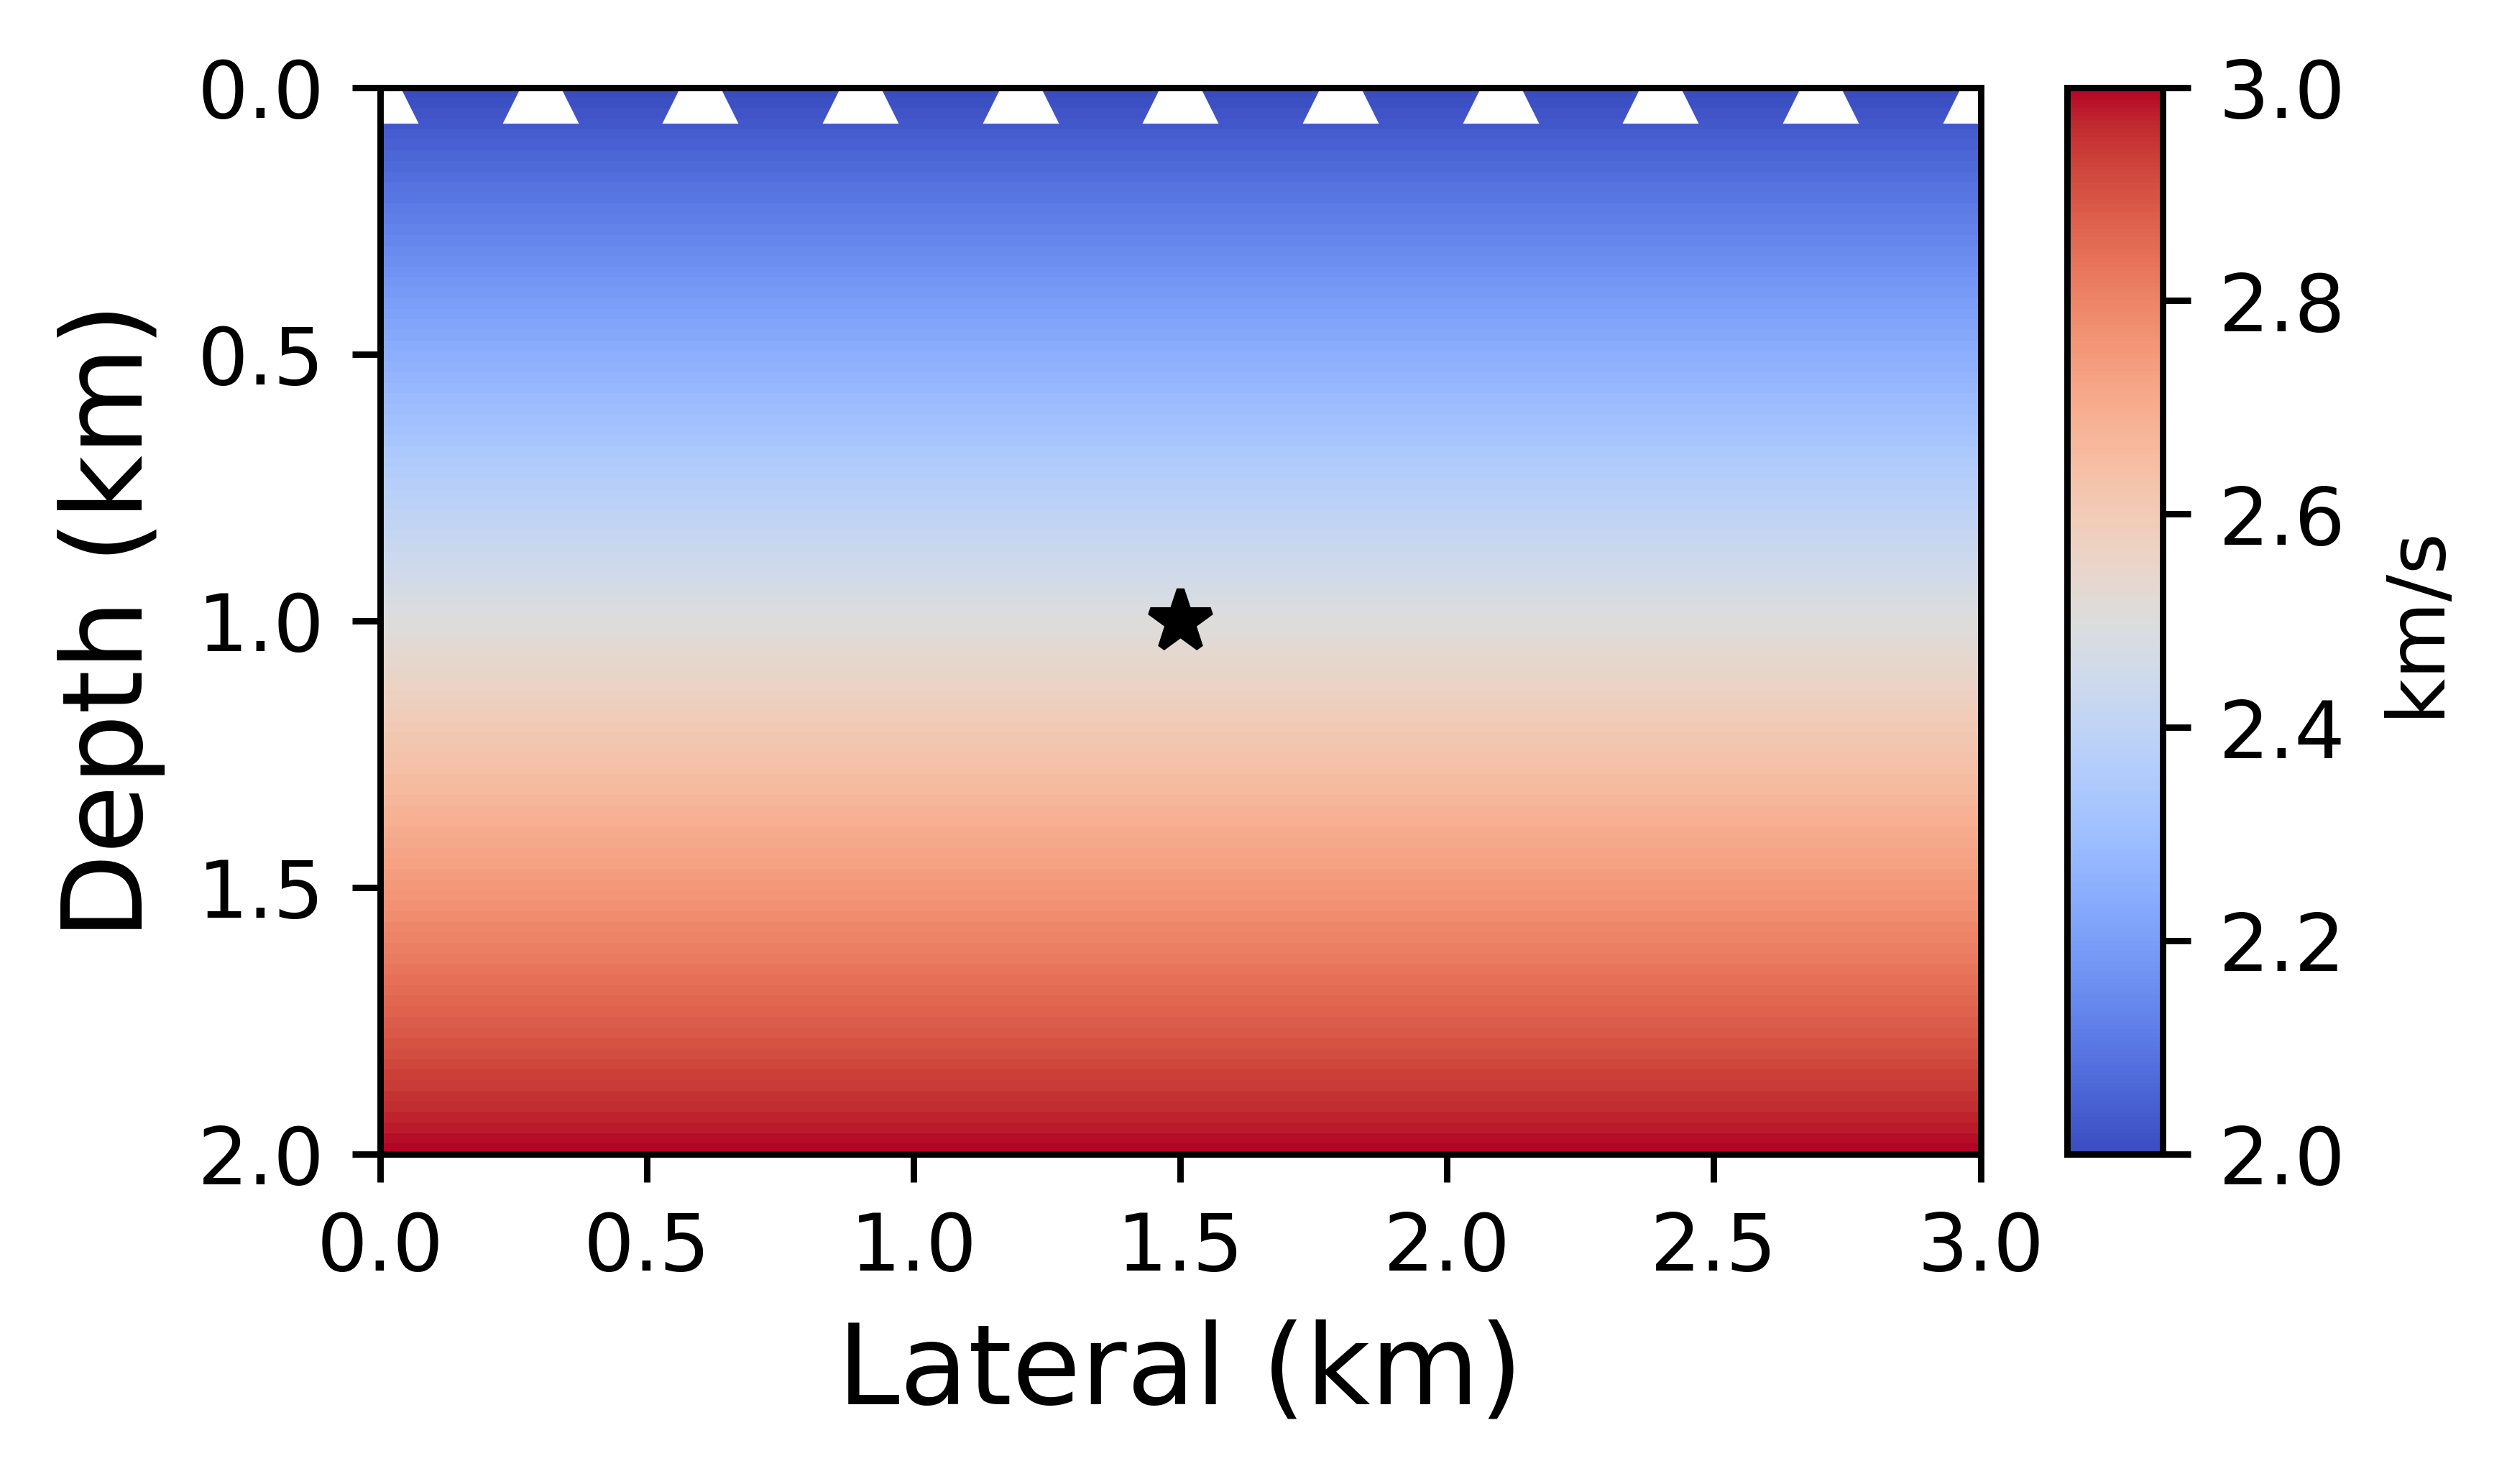

In [7]:
plt.style.use('default')

plt.figure(figsize=(4,4), dpi=800)

ax = plt.gca()
im = ax.imshow(velmodel, aspect=1, extent=[xmin, xmax, zmax, zmin],
               cmap='coolwarm')

ax.plot(sx, sz, 'k*', markersize=8)
ax.plot(Xd, Zd, 'w^', markersize=8)

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s', size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./Figures/ex2_vel.eps", format="eps", bbox_inches="tight", dpi=600)

# **Training the model**

In [8]:
def save_checkpoint(model, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
    }
    torch.save(checkpoint, filename)
    
def load_checkpoint(checkpoint_file, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])

In [9]:
# initialize PINN model and summary
initialization = 'kaiming_normal'
pinn = PINN(init=initialization).to(device)
pinn.train()
# initialize system
system = LossEikonal()

summary(pinn)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       48
│    └─Mish: 2-2                         --
│    └─Linear: 2-3                       272
│    └─Mish: 2-4                         --
│    └─Linear: 2-5                       544
│    └─Mish: 2-6                         --
│    └─Linear: 2-7                       1,056
│    └─Mish: 2-8                         --
│    └─Linear: 2-9                       528
│    └─Mish: 2-10                        --
│    └─Linear: 2-11                      272
│    └─Mish: 2-12                        --
│    └─Linear: 2-13                      17
Total params: 2,737
Trainable params: 2,737
Non-trainable params: 0

In [10]:
# maximum iterations
max_iter = 3001
total_loss = np.zeros((max_iter)) 
eqn_loss = np.zeros((max_iter)) 
data_loss = np.zeros((max_iter)) 


# Adam Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=5e-3, betas=(0.5, 0.9))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       max_iter, 
                                                       eta_min=0, 
                                                       last_epoch=- 1, 
                                                       verbose=False)

# training start
iterations = tqdm(range(max_iter))
start_time = time.time()
for j in iterations:
    loss, loss_eq, loss_data = system(pinn, params)

    loss.backward()
    optimizer.step()
    scheduler.step()

    optimizer.zero_grad()

    total_loss[j] = loss.item()
    eqn_loss[j] = loss_eq.item()
    data_loss[j] = loss_data.item()
    iterations.set_postfix(loss=loss.item())

elapsed = time.time() - start_time                
print('\nTraining time: %.2f' % (elapsed))
save_checkpoint(pinn, filename="EX2.pth")

100%|█████████████████████████| 3001/3001 [00:57<00:00, 52.15it/s, loss=3.53e-5]


Training time: 57.55
=> Saving checkpoint


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


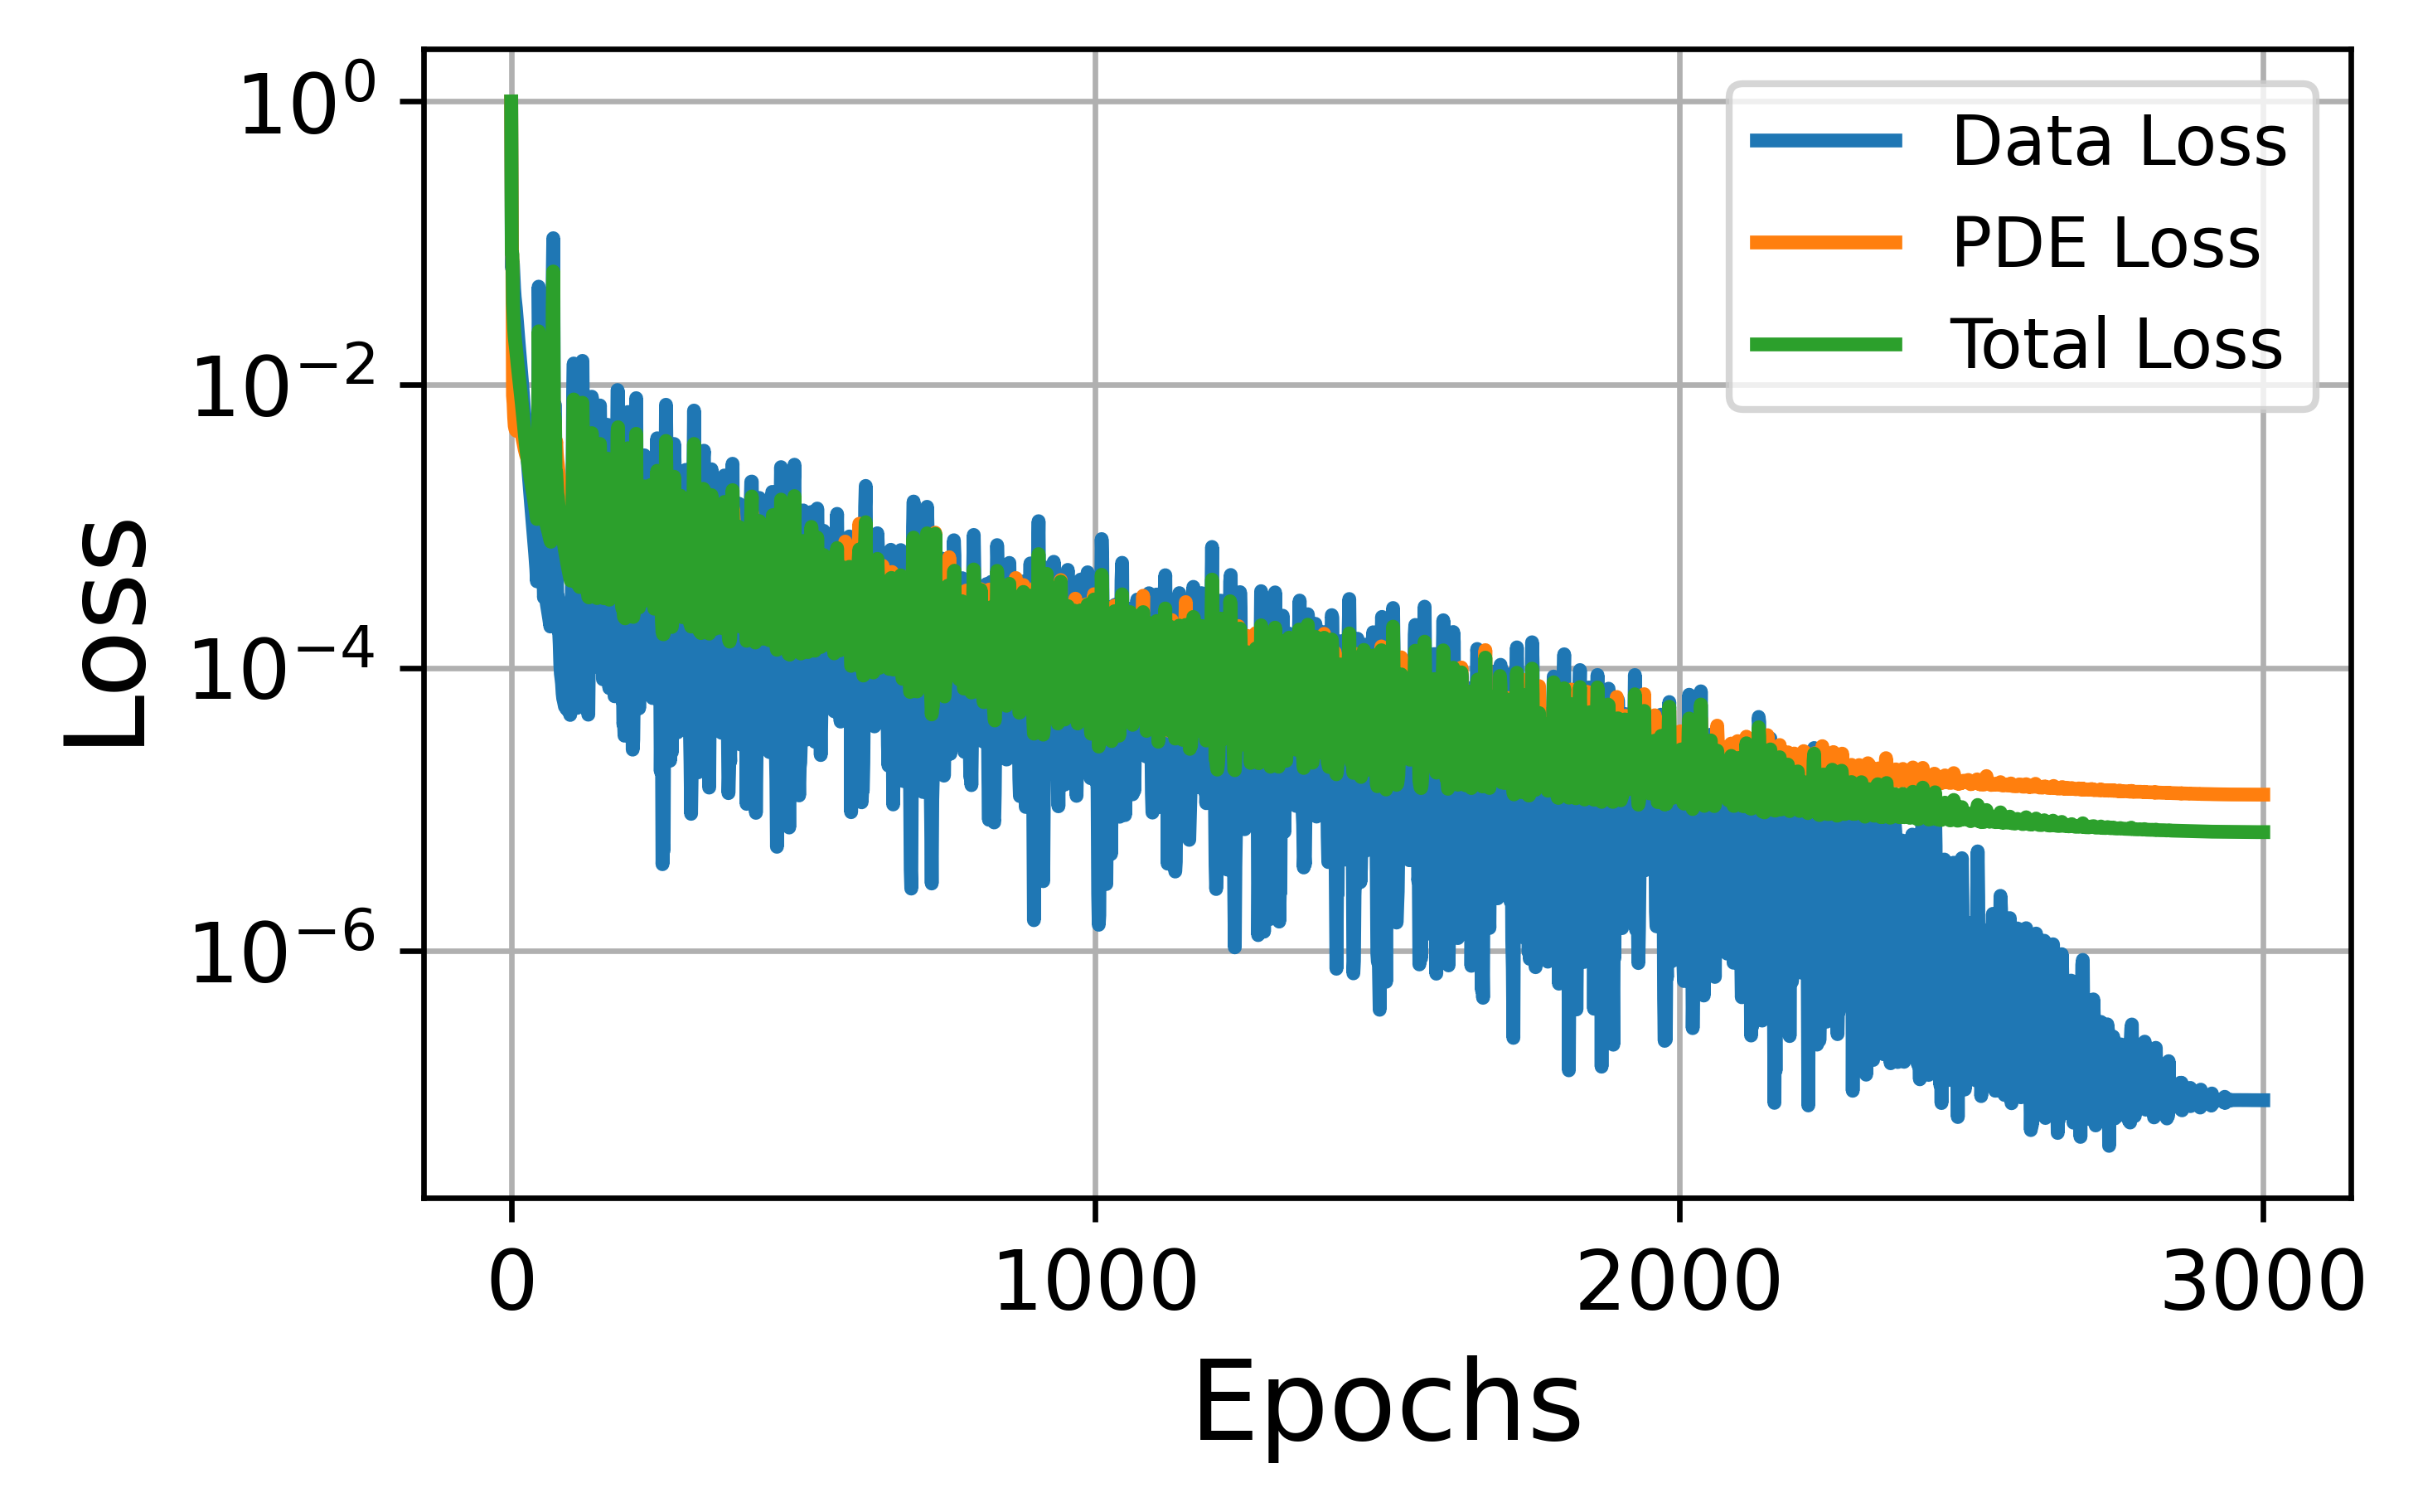

In [11]:
# Total Loss
fig = plt.figure(figsize=(5, 3), dpi=600)
ax = plt.axes()
ax.semilogy(data_loss / np.max(data_loss), linewidth=2, label='Data Loss')
ax.semilogy(eqn_loss / np.max(eqn_loss), linewidth=2, label='PDE Loss')
ax.semilogy(total_loss / np.max(total_loss), linewidth=2, label='Total Loss')

ax.set_xlabel('Epochs', fontsize=16)

plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))

ax.set_ylabel('Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='upper right')

# plt.savefig("./Figures/ex2_loss.eps", format="eps", bbox_inches="tight", dpi=600)

# **Prediction**

In [12]:
T_data = T_data.detach().cpu().numpy()

In [13]:
# predicting traveltime solution from the trained model
pinn.eval()
pred = pinn(testset)
T_pred = pred.reshape(Z.shape).detach().cpu().numpy()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


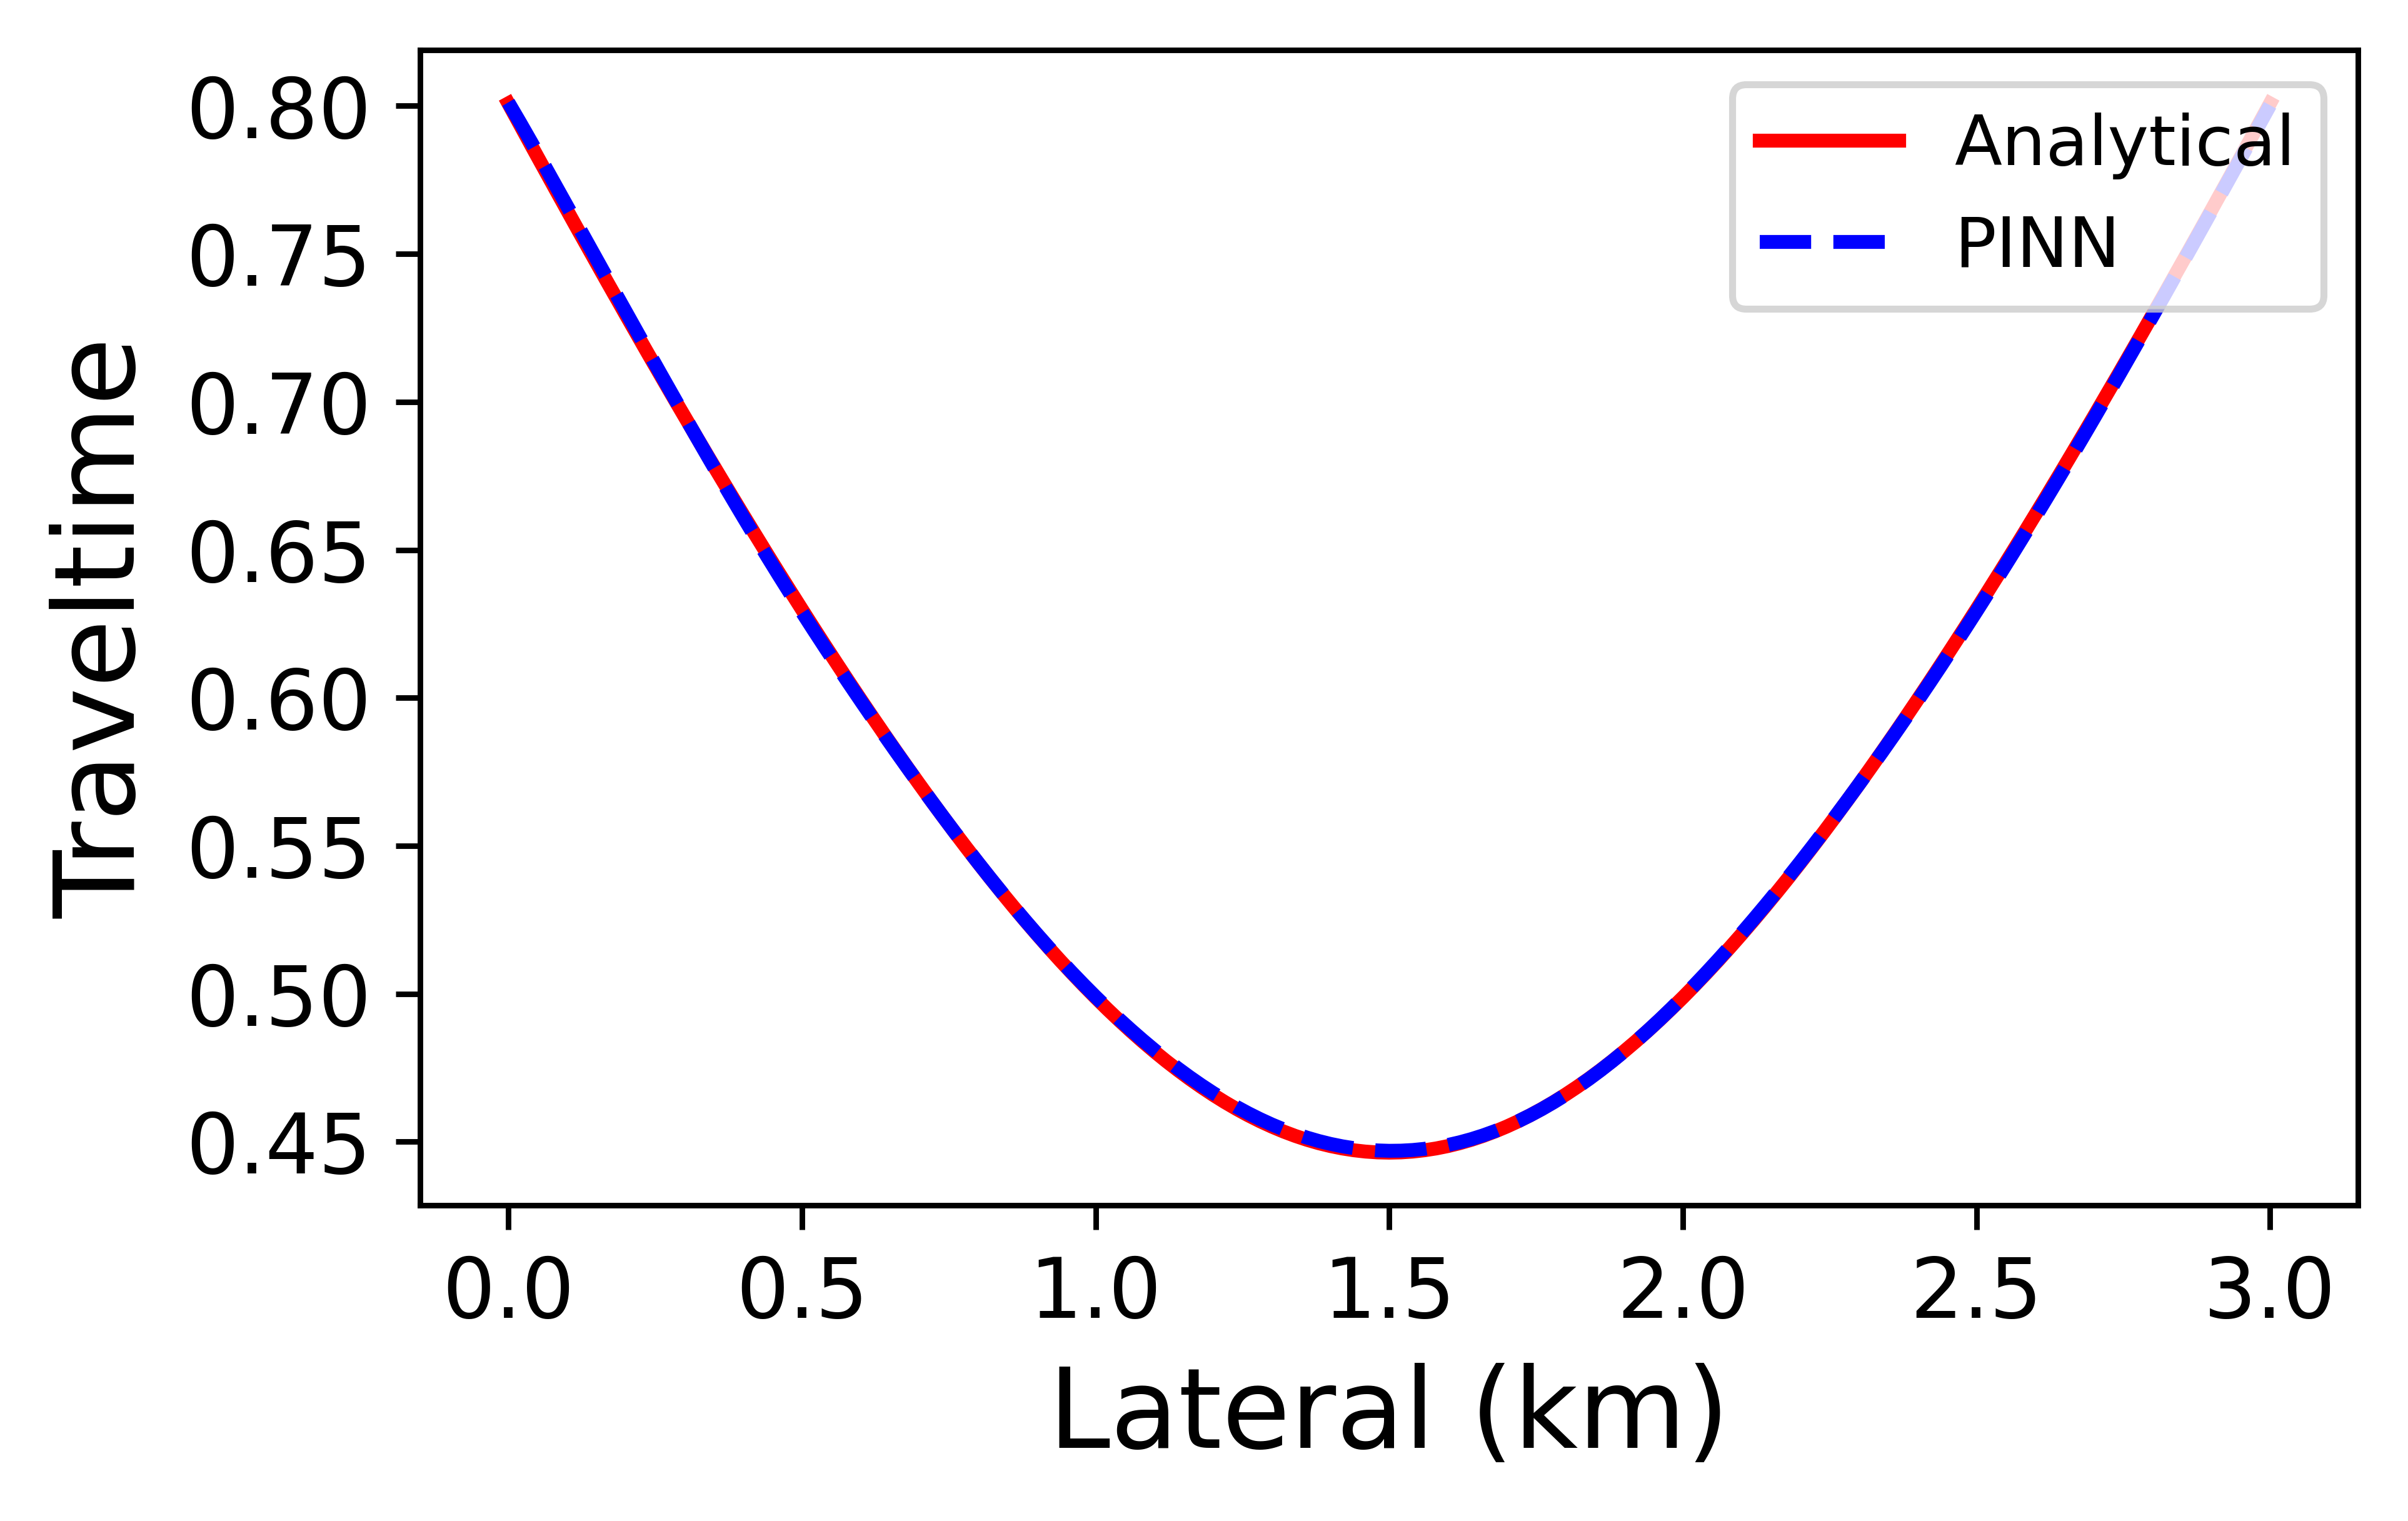

In [14]:
fig = plt.figure(figsize=(5, 3), dpi=800)
ax = plt.axes()
ax.plot(x, T_data[0, :],'r-', linewidth=2, label='Analytical')
ax.plot(x, T_pred[0, :],'b--', linewidth=2, label='PINN')


ax.set_xlabel('Lateral (km)', fontsize=16)
plt.xticks(fontsize=12)

ax.set_ylabel('Traveltime', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

# plt.savefig("./Figures/ex2_data_fit.eps", format="eps", bbox_inches="tight", dpi=600)

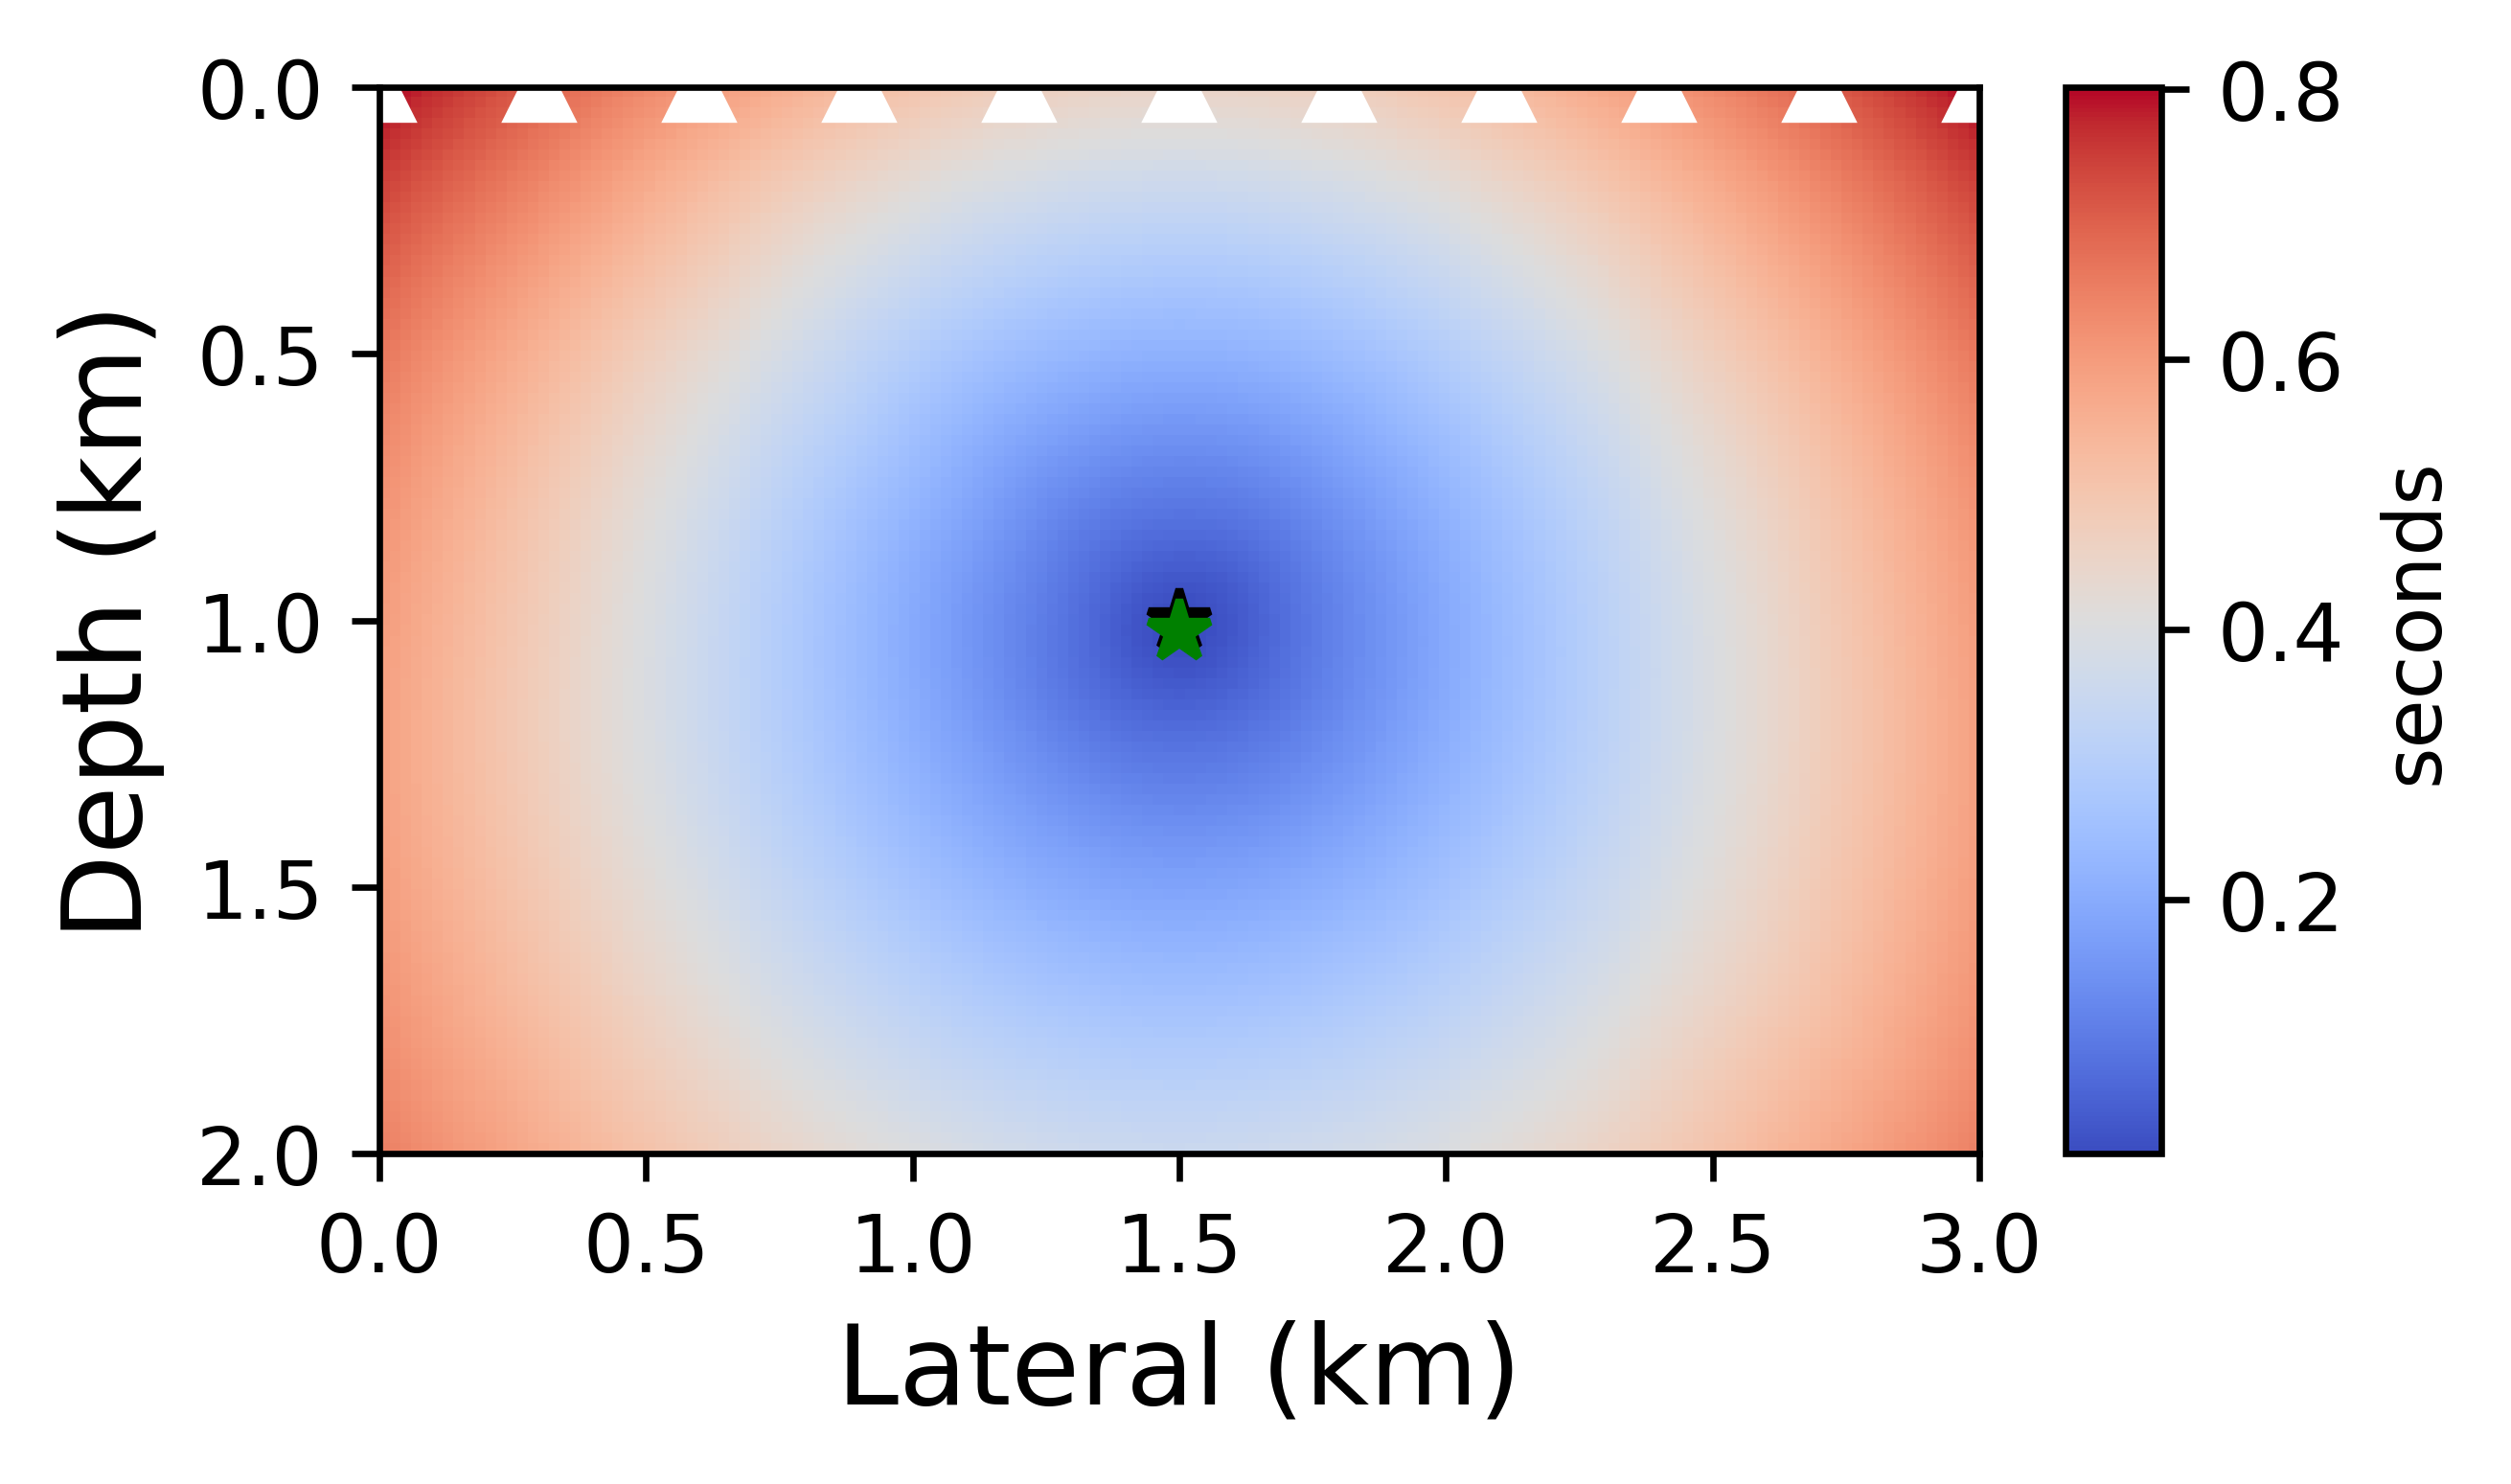

In [15]:
# plot the PINN solution error
ssz, ssx = np.where(T_pred == np.min(T_pred))
ss = (deltax*ssx[0], deltaz*ssz[0])

plt.style.use('default')
plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(T_pred, extent=[xmin, xmax, zmax, zmin],
               aspect=1, cmap='coolwarm')

ax.plot(sx, sz, 'k*', markersize=8)
ax.plot(Xd, Zd, 'w^', markersize=8)
ax.plot(ss[0], ss[1], 'g*', markersize=8)

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds', size=10)
cbar.ax.tick_params(labelsize=10)
    
# plt.savefig(f"./Figures/ex2_solution.eps", format="eps", bbox_inches="tight", dpi=600)

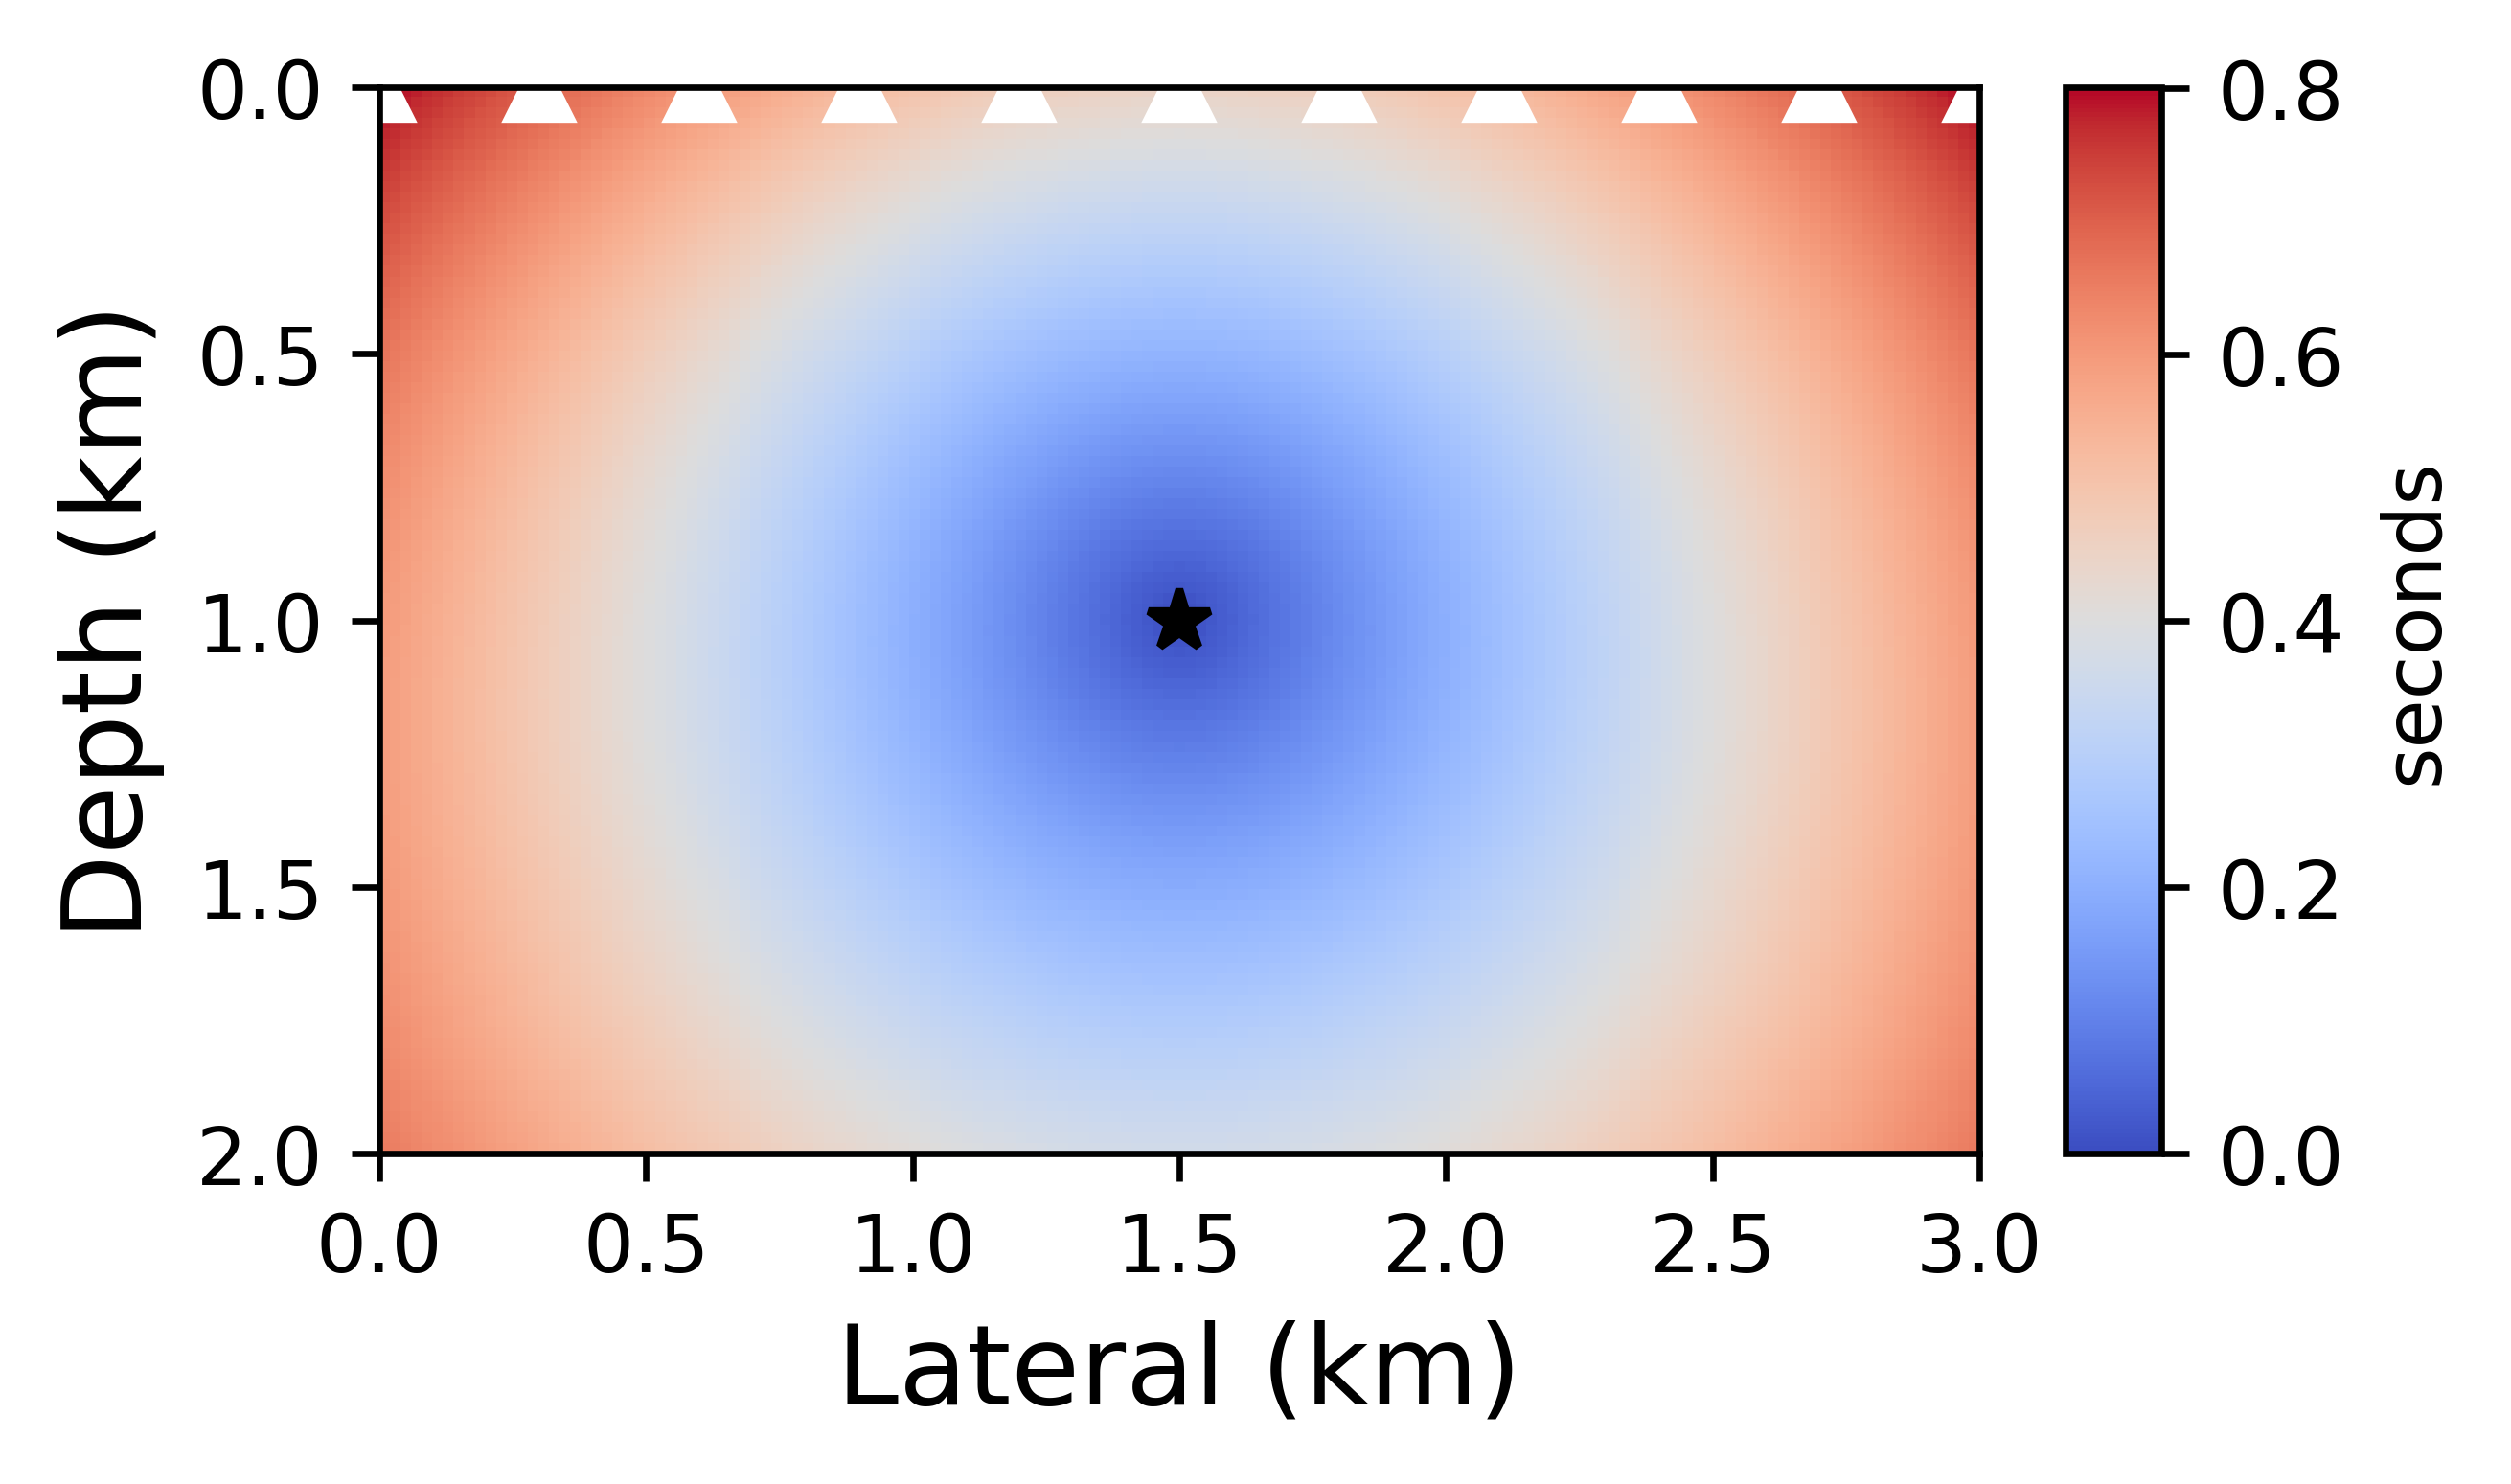

In [16]:
# plot the PINN solution error

plt.style.use('default')
plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(T_data, extent=[xmin, xmax, zmax, zmin],
               aspect=1, cmap='coolwarm')

ax.plot(sx, sz, 'k*', markersize=8)
ax.plot(Xd, Zd, 'w^', markersize=8)

# plt.title('Analytical')

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds', size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(f"./Figures/ex2_solution_analytical.eps", format="eps", bbox_inches="tight", dpi=600)

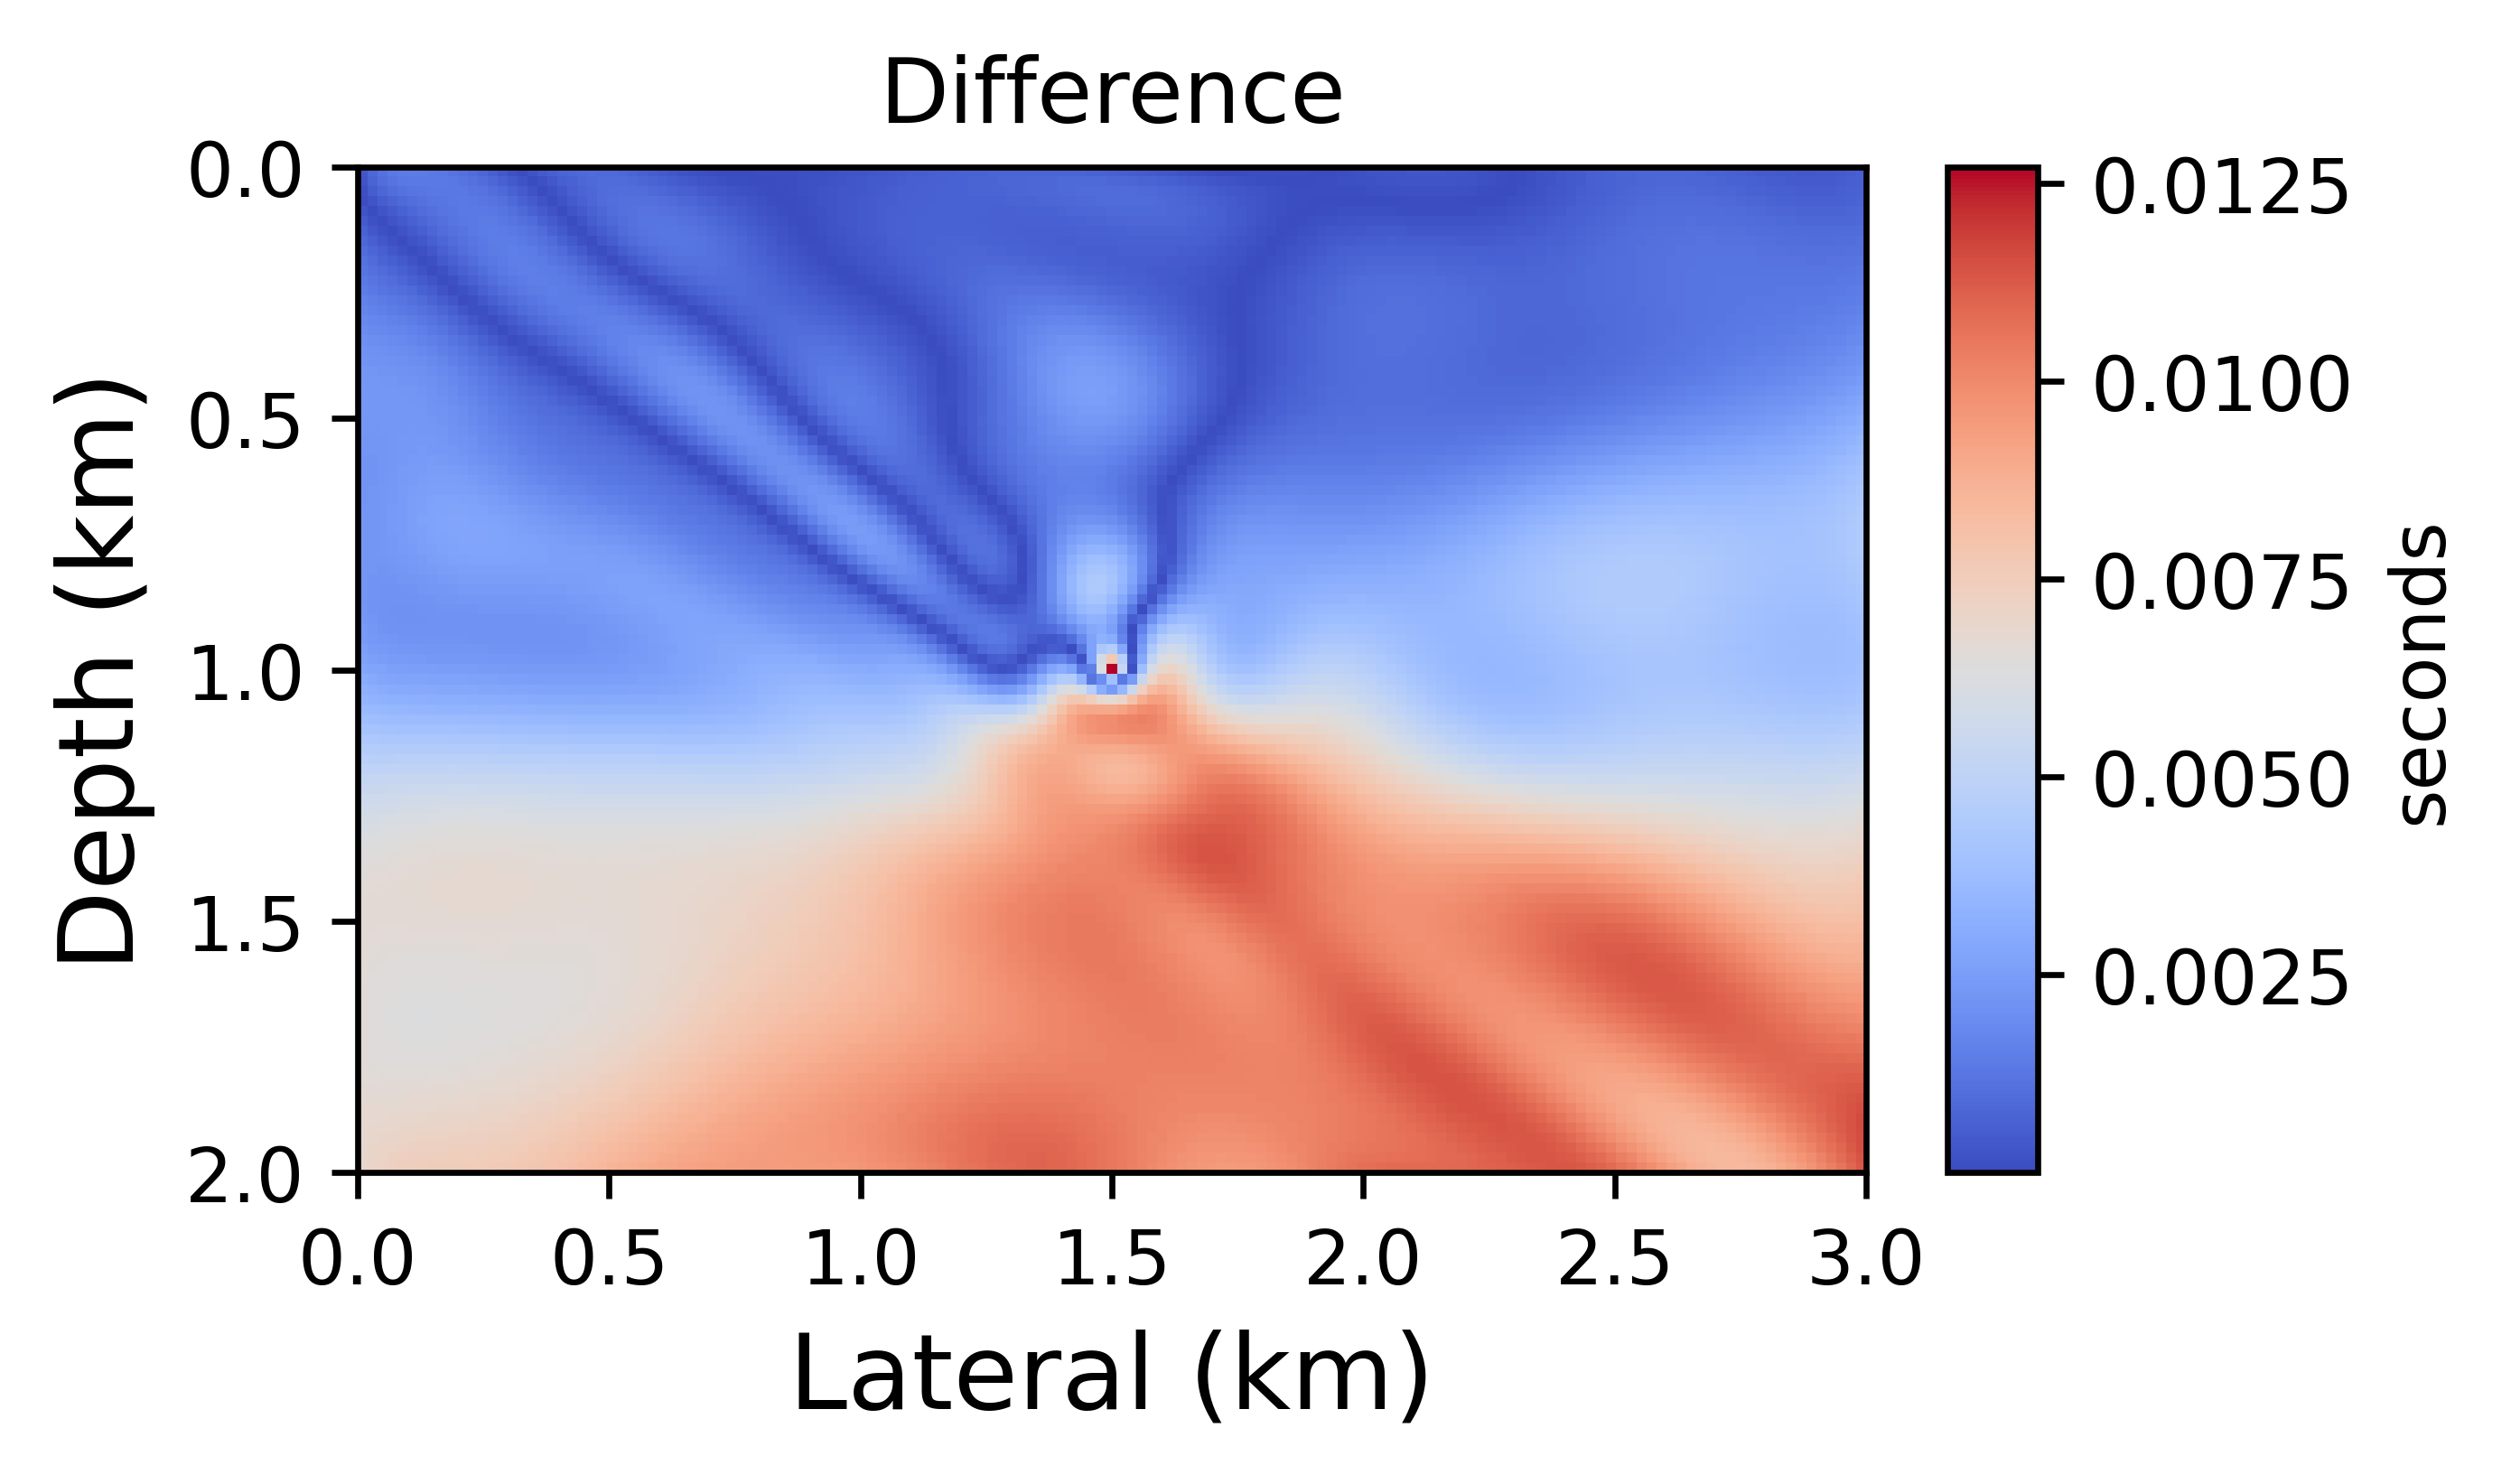

In [17]:
# plot the PINN solution error
plt.style.use('default')
plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(np.abs(T_pred - T_data), extent=[xmin, xmax, zmax, zmin],
               aspect=1, cmap='coolwarm')

plt.title('Difference')

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds', size=10)
cbar.ax.tick_params(labelsize=10)
    
# plt.savefig(f"./Figures/ex2_solution_error.eps", format="eps", bbox_inches="tight", dpi=600)

In [18]:
ssz, ssx = np.where(T_pred == np.min(T_pred))
ss = (deltax*ssx[0], deltaz*ssz[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


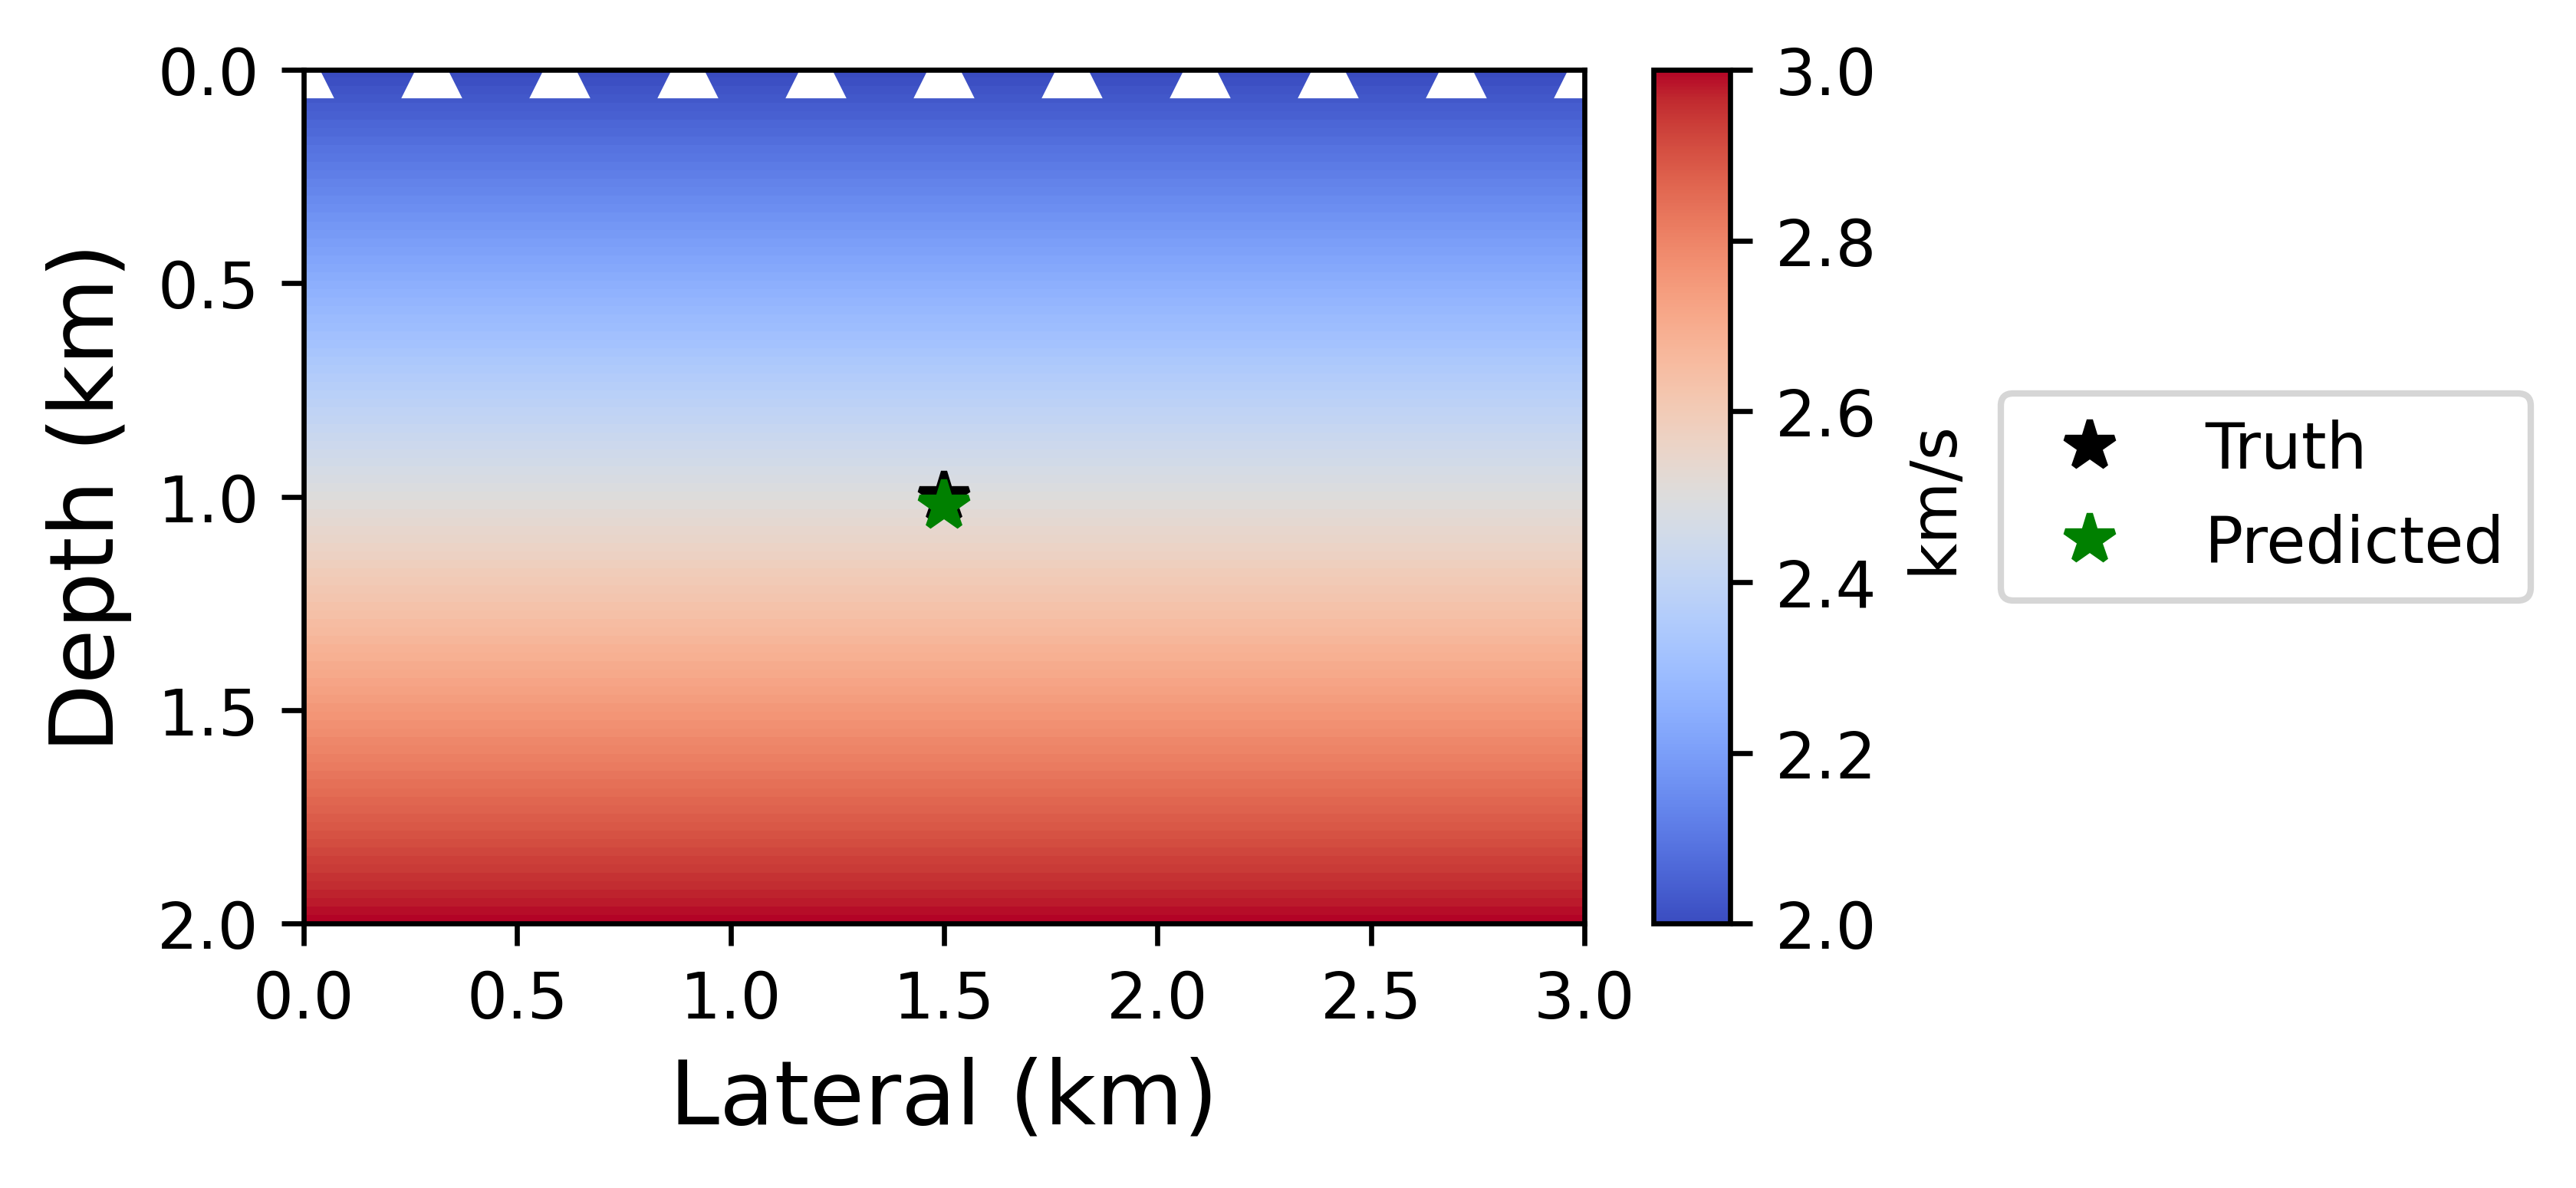

In [19]:
plt.style.use('default')

plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(velmodel, aspect=1, extent=[xmin, xmax, zmax, zmin],
               cmap='coolwarm')

ax.plot(Xd, Zd, 'w^', markersize=8)
ax.plot(sx, sz, 'k*', markersize=8, label='Truth')
ax.plot(ss[0], ss[1], 'g*', markersize=8, label='Predicted')

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s', size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(f"./Figures/ex2_solution_hypo.eps", format="eps", bbox_inches="tight", dpi=600)

# **The diagonal Fisher information matrix (FiM) \& Kronecker factorization \& Eigenvalue correction**

In [20]:
pinn.train()
diag = Diagonal(pinn)
kfac = KFAC(pinn)

# A rank-10 diagonal FiM approximation.
for sample in range(1000):
    
    # training
    selected_pts = np.random.choice(np.arange(Z.numel()), num_tr_pts, replace=True)
    Zf = Z.reshape(-1, 1)[selected_pts]
    Xf = X.reshape(-1, 1)[selected_pts]

    # velocity
    velmodelf = velmodel.reshape(-1, 1)[selected_pts].requires_grad_(False).to(device)

    # grid points for training
    trainset = torch.hstack((Zf, Xf)).requires_grad_(True).to(device)

    # params
    params = {'vel':velmodelf, 'input':trainset, 'data_pts':dataset, 'data':data}
    
    loss, loss_eq, loss_data = system(pinn, params)

    pinn.zero_grad()
    loss.backward(retain_graph=True)

    diag.update(batch_size=num_tr_pts)
    kfac.update(batch_size=num_tr_pts)
    
    efb = EFB(pinn, kfac.state)
    efb.update(batch_size=num_tr_pts)

# **Sparse Information Form**

In [21]:
inf = INF(pinn, diag.state, kfac.state, efb.state)
inf.update(rank=10000)

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 108.00it/s]


# **Inversion and Sampling**

In [22]:
estimator = diag
add = 1e3
multiply = 1e-3
estimator.invert(add, multiply)

In [23]:
num_samples = 1000  # 10 Monte Carlo samples from the weight posterior.
pinn.eval()
samples = []
sxr = np.zeros(num_samples)
szr = np.zeros(num_samples)

with torch.no_grad():
    for i in tqdm(range(num_samples)):
        estimator.sample_and_replace()
        T_pred = pinn(testset)
        T_pred = T_pred.reshape(Z.shape).detach().cpu().numpy()
        ssz, ssx = np.where(T_pred == np.min(T_pred))
        samples.append(T_pred)
        sxr[i] = deltax*ssx[0]
        szr[i] = deltaz*ssz[0]
        
samples = np.array(samples)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 391.68it/s]


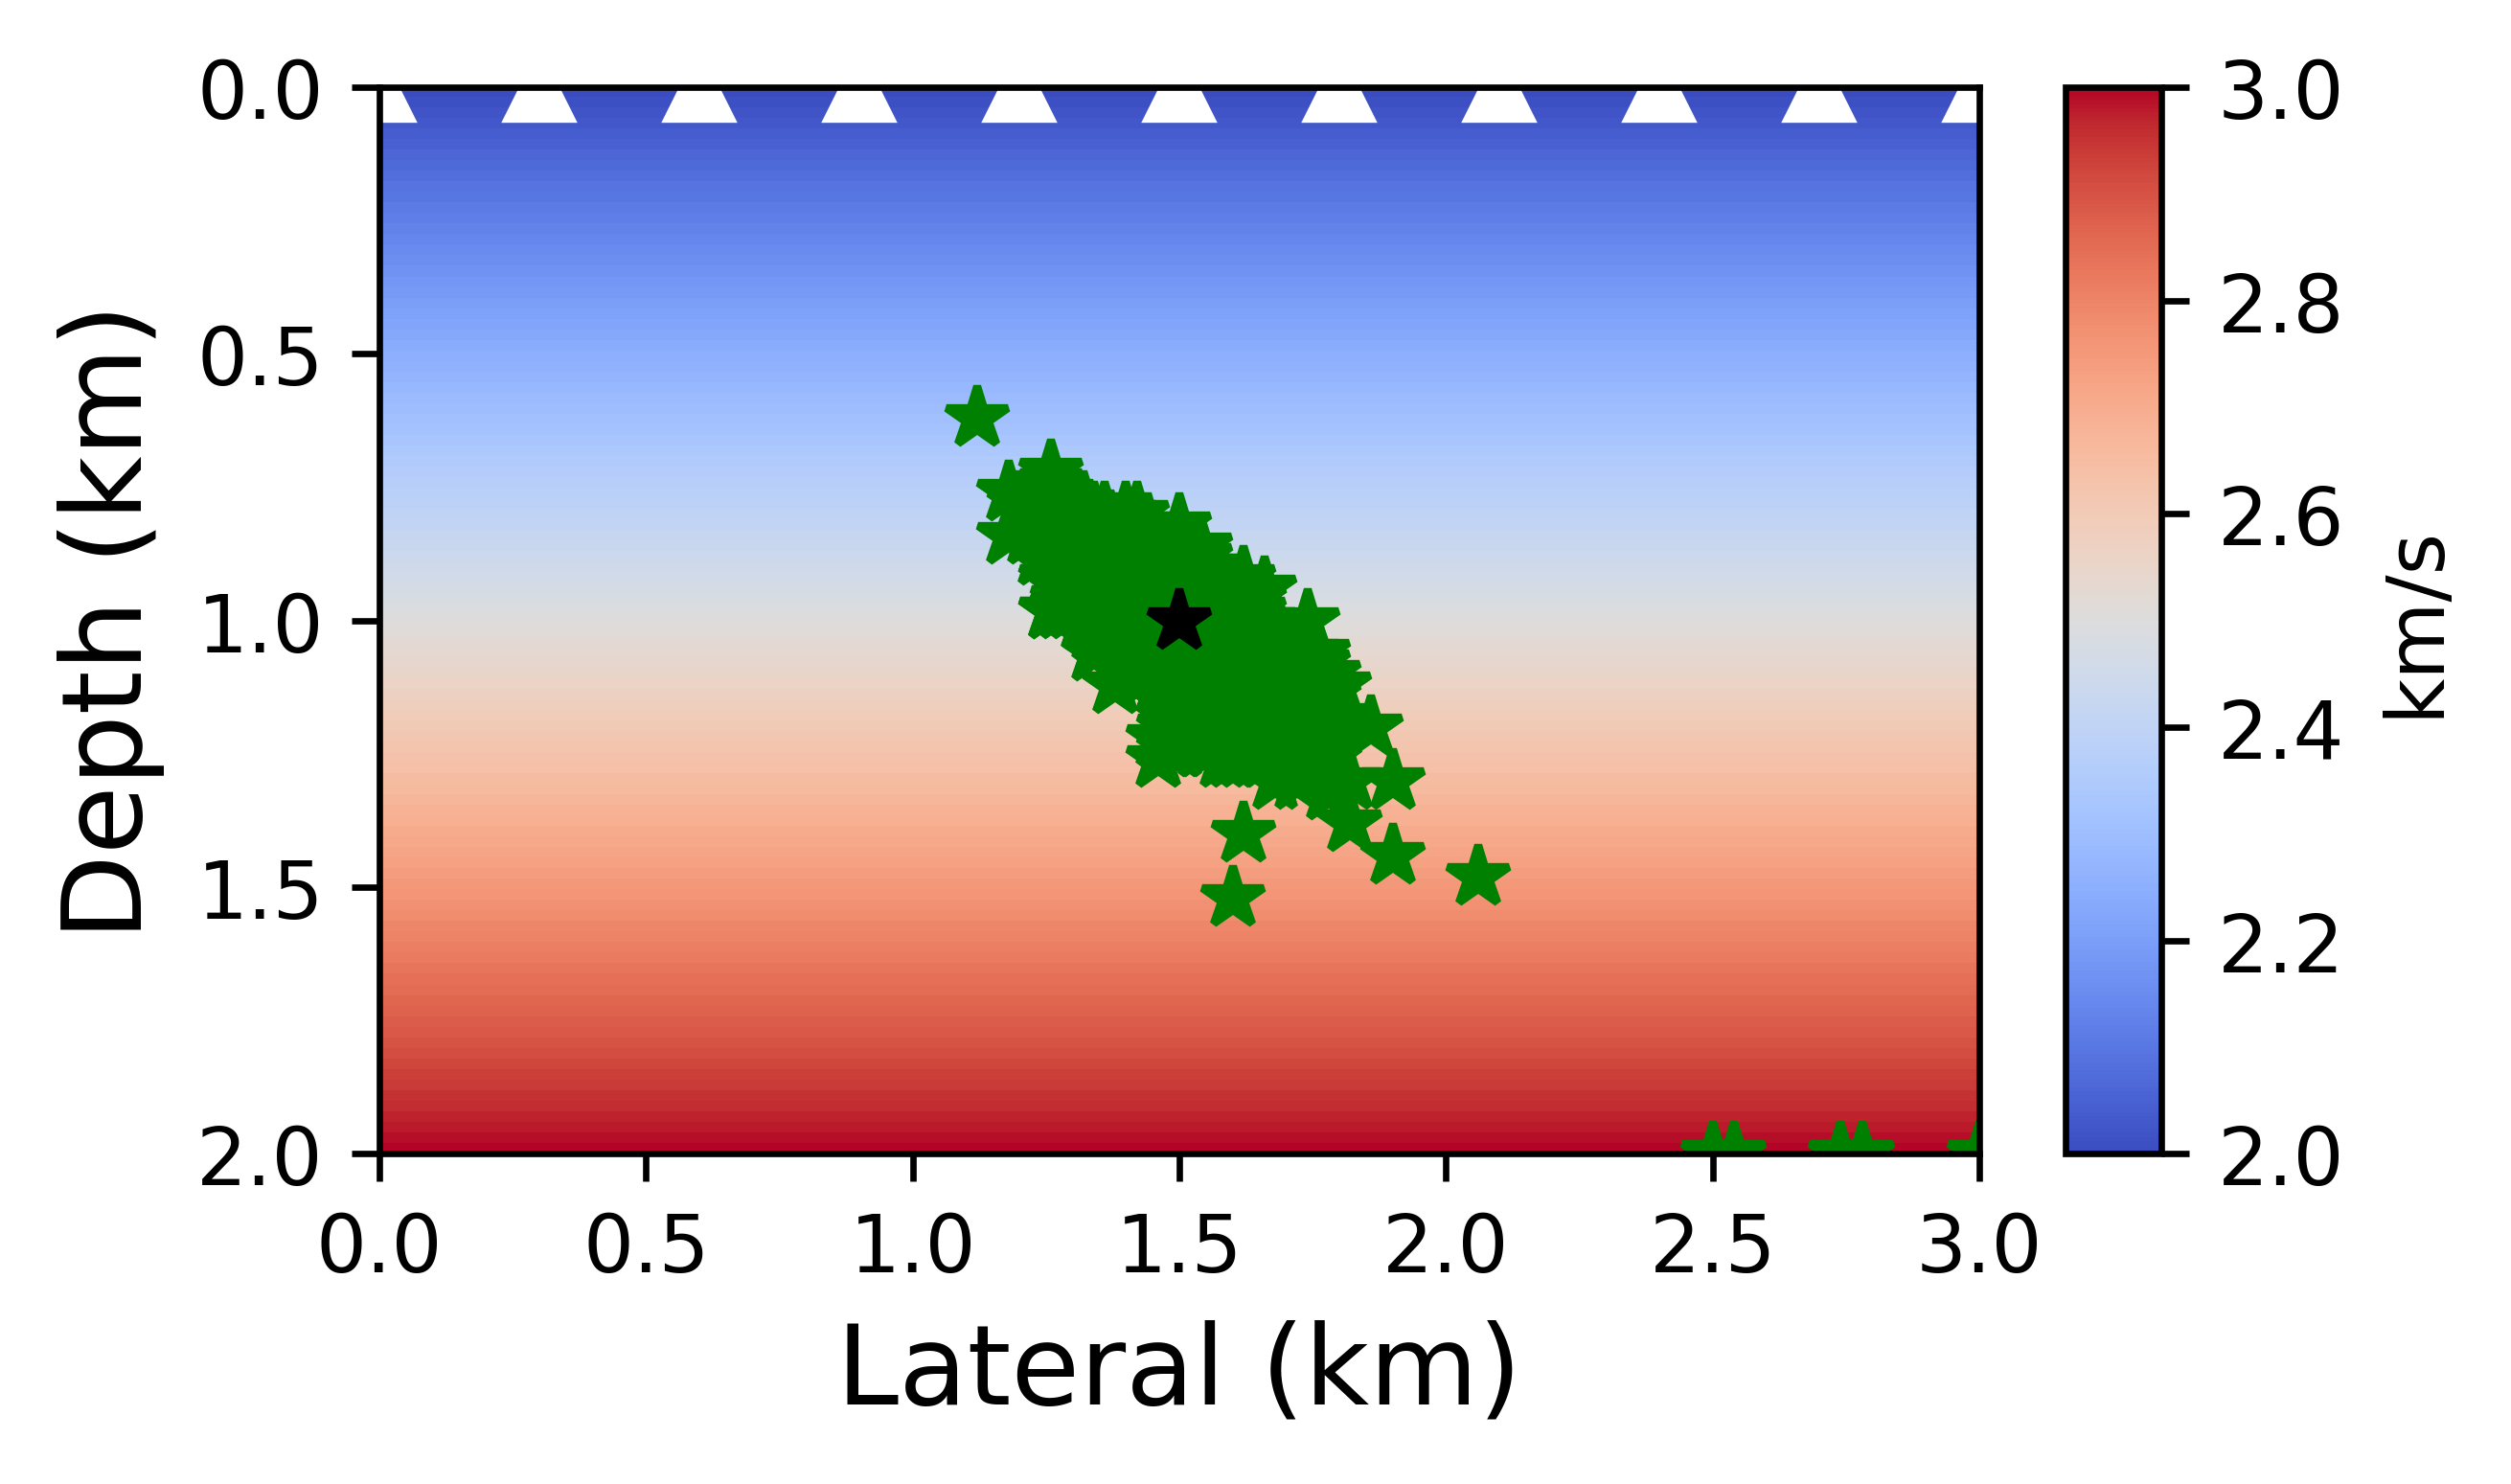

In [24]:
plt.style.use('default')
plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(velmodel, aspect=1, extent=[xmin, xmax, zmax, zmin],
               cmap='coolwarm')

ax.plot(sxr, szr, 'g*', markersize=8)
ax.plot(Xd, Zd, 'w^', markersize=8)
ax.plot(sx, sz, 'k*', markersize=8)

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s', size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig(f"./Figures/ex2_solution_laplace.eps", format="eps", bbox_inches="tight", dpi=600)

Text(0.5, 0, 'Source position')

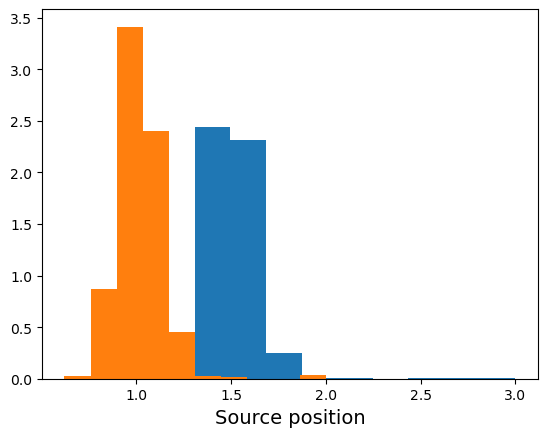

In [25]:
counts_x, bins_x = np.histogram(sxr)
counts_z, bins_z = np.histogram(szr)


plt.hist(bins_x[:-1], histtype='stepfilled', density=True, bins=bins_x, weights=counts_x, stacked=True)
plt.hist(bins_z[:-1], histtype='stepfilled', density=True, bins=bins_z, weights=counts_z, stacked=True)
plt.xlabel('Source position', fontsize=14)
# plt.ylabel('Histogram')
# plt.title('Lateral Source Position', fontsize=14)

In [26]:
std_sx = sxr.std()
std_sz = szr.std()

In [27]:
std_sx

0.14485133758443516

In [28]:
std_sz

0.12714394834202689